In [1]:
from box import Box
import yaml
import matplotlib.pyplot as plt
import numpy as np
from pyts.classification import LearningShapelets
from pyts.datasets import load_gunpoint
from pyts.utils import windowed_view
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import classification_report
import pickle
%matplotlib inline

In [2]:
path = "./data/erg_temp.xlsx"
signal_type = "Maximum 2.0 ERG Response"
columns = ["Age", "la", "a", "lb", "b", "diag"]
test_ratio = 0.3
save_path = "./saved_models"


In [3]:
def prepared_data():
    data = pd.read_excel(path, sheet_name=0)
    data.head()
    signal_type = "Maximum 2.0 ERG Response"
    new_data = pd.DataFrame()
    for i in range(7):
        row = data.iloc[i, :].values
        new_data[row[0]] = row[1:]
    new_data["signal_type"] = signal_type
    new_data["signal"] = [data[col].values[9:210].tolist() for col in data.columns[1:]]
    new_data["Diagnosis"] = new_data["Diagnosis"].map({"healthy": 0, "unhealthy": 1})
    new_data = new_data.dropna(axis=0)
    return new_data

In [4]:
def get_class_distribution(y):
    return np.unique(y, return_counts=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


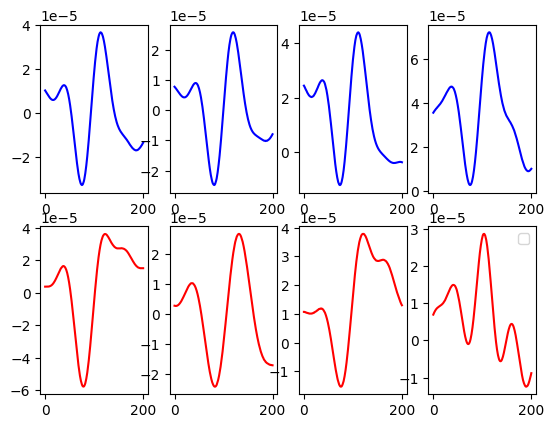

,PatNo,Age,Diagnosis,a-wave latency (la),a-wave amplitude (a),b-wave latency (lb),b-wave amplitude (b),signal_type,signal
0,3,27.86,1,20.5,51.602914,41,71.141256,Maximum 2.0 ERG Response,"[3.71e-06, 3.66e-06, 3.6e-06, 3.53e-06, 3.45e-..."
1,3,27.86,0,18.5,45.458349,40,83.424715,Maximum 2.0 ERG Response,"[-2.35, -2.47, -2.63, -2.8, -3.01, -3.24, -3.4..."
2,5,37.11,1,19,34.029953,37.5,52.252863,Maximum 2.0 ERG Response,"[1.26e-05, 1.24e-05, 1.22e-05, 1.2e-05, 1.18e-..."
3,6,31.68,1,19,113.258301,41,196.823552,Maximum 2.0 ERG Response,"[-10.8, -11.1, -11.5, -11.9, -12.4, -12.9, -13..."
4,6,31.69,1,19.5,46.341539,41,78.289791,Maximum 2.0 ERG Response,"[1.15e-06, 9.6e-07, 7.46e-07, 5.06e-07, 2.44e-..."


In [5]:
new_data = prepared_data()
unhealthy_signals = new_data[new_data["Diagnosis"] == 1]["signal"].values
healthy_signals = new_data[new_data["Diagnosis"] == 0]["signal"].values
np.random.shuffle(unhealthy_signals)
np.random.shuffle(healthy_signals)
fig, ax = plt.subplots(2, 4)
for k, signal in enumerate(healthy_signals[:4]):
    ax[0][k].plot(signal, color='b')
for k, signal in enumerate(unhealthy_signals[:4]):
    ax[1][k].plot(signal, color = 'r')
    
# plt.plot(new_data["signal"].values[0], color="r", label="unhealthy")
# plt.plot(new_data["signal"].values[1], color="g", label="healthy")
plt.legend()
plt.show()
new_data.head()


<Axes: xlabel='Diagnosis'>

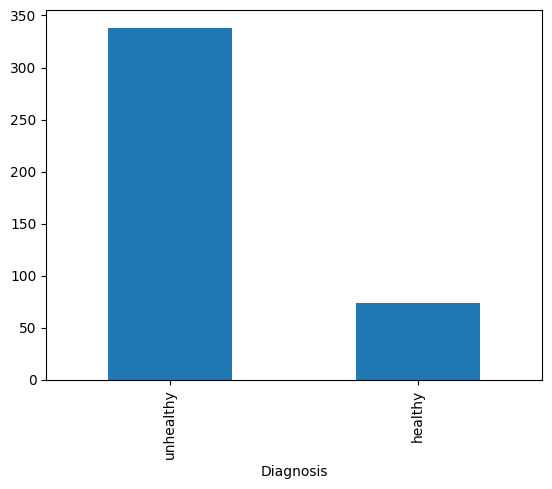

In [6]:
new_data['Diagnosis'].map({1:"unhealthy", 0:"healthy"}).value_counts().plot.bar()


In [6]:
def get_shapelets(X, y, num_shapelets, save=True):
    # Load the data set and fit the classifier
    print("data shape:", X.shape)
    #clf = LearningShapelets(random_state=42, tol=0.01, class_weight="balanced")
    #clf.fit(X, y)
    with open("data/shaplet_transform_clf.pkl", "rb") as f:
        clf = pickle.load(f)
    
    # Select two shapelets
    coefs = clf.coef_[0]
    sorted_coefs = np.argsort(coefs)[::-1][:num_shapelets]
    distance_df = pd.DataFrame()
    for i, ind in enumerate(sorted_coefs):
        
        shapelets = np.asarray([clf.shapelets_[0, ind]])

        # Derive the distances between the time series and the shapelets
        shapelet_size = shapelets.shape[1]
#         print("shapelet size:", shapelet_size)
        X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
        X_dist = np.mean(
            (X_window[:, :, None] - shapelets[None, :]) ** 2, axis=3).min(axis=1)
#         print("distance shape;", X_dist.ravel().shape)
        plt.figure(figsize=(14, 4))

        # Plot the two shapelets
        plt.subplot(1, 2, 1)
        plt.plot(shapelets[0])
        plt.title('Learned shapelet', fontsize=14)

        # Plot the distances
        plt.subplot(1, 2, 2)
        plt.hist(X_dist[y == 0, 0], bins = len(X_dist)//8, color="g", label = "healthy")
        # plt.hist(X_dist[y == 1, 1], bins = 20, color="g", label = "Class 1 shaplet 2")
        plt.hist(X_dist[y == 1, 0], bins=len(X_dist)//8, color="r", label = "unhealthy")
        # plt.hist(X_dist[y == 2, 1], bins = 20, color="c", label = "Class 2 shaplet 2")
        # for color, label in zip('br', (1, 2)):
        #     plt.scatter(X_dist[y == label, 0], X_dist[y == label, 1],
        #                 c=color, label='Class {}'.format(label))
        plt.title('Distances between the time series and shapelet',
                fontsize=14)
        plt.legend()
        # plt.show()
        plt.savefig("figs/shapelets/" + str(i) + ".png")
        distance_df["shapelet_" + str(i)] = X_dist.ravel()
    
    return distance_df, clf
    

In [7]:
def pickle_load(path):
    with open(path, "rb") as f:
        return pickle.load(f)

In [9]:
X, y = np.array(new_data["signal"].values.tolist()), np.array(new_data["Diagnosis"].values.tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# print("train shape and counts:", y_train.shape, get_class_distribution(y_train)[1])
# print("test shape and counts:", y_test.shape, get_class_distribution(y_test)[1])
# np.save("data/X_train.npy", X_train)
# np.save("data/X_test.npy", X_test)
# np.save("data/y_train.npy", y_train)
# np.save("data/y_test.npy", y_test)

In [1]:
# add other parameters
def train_kfold(model, X, y, X_train, y_train, kfolds, random_state):
    skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=random_state)

    average_precisions = []
    
    for fold, (tr, te) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]

        model.fit(X_tr, y_tr)
        y_pr = model.predict_proba(X_te)[:,1]
        aps = average_precision_score(y_te, y_pr)
        average_precisions.append(aps)
    
    return model, np.mean(average_precisions)

def test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    class_names = ["healthy", "unhealthy"]
    print(classification_report(y_test, y_pred, target_names=class_names), "\n")

def train(model, data, y, num_shapelets, other_cols, test_ratio=0.2, kfold_splits = 10, random_state = 42):
    # get shapelet and their distances
    X_dist = pickle_load("data/shaplet_distances100.pkl")
    X_dist = X_dist[X_dist.columns[:num_shapelets]]
    # add other columns
    for col in other_cols:
        X_dist[col] = data[col]
    
    print("training with columns:", X_dist.columns)
    # prepare data
    X = X_dist.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state)
    model, mean_precision = train_kfold(model, X, y, X_train, y_train, kfold_splits, random_state)
    
    # test model
    test(model, X_test, y_test)
    return mean_precision

In [11]:
from sklearn.datasets import load_iris
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


# Define the parameter grid for each model
decision_tree_params = {
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

random_forest_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

logistic_regression_params = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs']
}

svm_params = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf']
}

# Perform randomized grid search for each model
models = [
    ('Decision Tree', DecisionTreeClassifier(), decision_tree_params),
    ('Random Forest', RandomForestClassifier(), random_forest_params),
    ('Logistic Regression', LogisticRegression(), logistic_regression_params),
    ('SVM', SVC(), svm_params)
]

for model_name, model, params in models:
    print(f"Performing randomized grid search for {model_name}...")
    random_search = RandomizedSearchCV(model, params, n_jobs = 2, n_iter=20, cv=3, random_state=42)
    random_search.fit(X, y)
    best_params = random_search.best_params_
    print(f"Best parameters for {model_name}:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print()


Performing randomized grid search for Decision Tree...


/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Decision Tree:
min_samples_split: 10
max_depth: 3

Performing randomized grid search for Random Forest...
Best parameters for Random Forest:
n_estimators: 10
min_samples_split: 2
max_depth: 3

Performing randomized grid search for Logistic Regression...


/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches,

Best parameters for Logistic Regression:
solver: lbfgs
C: 0.1

Performing randomized grid search for SVM...
Best parameters for SVM:
kernel: rbf
C: 10.0



/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [2]:
columns = ['Age', 'a-wave latency (la)','a-wave amplitude (a)','b-wave latency (lb)','b-wave amplitude (b)']
num_shapelets = 0 
model = RandomForestClassifier(n_jobs=-1, random_state=42)
y = np.array(new_data["Diagnosis"].values.tolist())
mean_precision = train(model, new_data, y, num_shapelets, columns)
print("mean precision:", mean_precision, '\n')

columns = ['Age', 'a-wave latency (la)','a-wave amplitude (a)','b-wave latency (lb)','b-wave amplitude (b)']
num_shapelets = 2 
model = RandomForestClassifier(n_jobs=-1, random_state=42)
y = np.array(new_data["Diagnosis"].values.tolist())
mean_precision = train(model, new_data, y, num_shapelets, columns)
print("mean precision:", mean_precision, '\n')

columns = ['a-wave latency (la)','a-wave amplitude (a)','b-wave latency (lb)','b-wave amplitude (b)']
num_shapelets = 5 
model = RandomForestClassifier(n_jobs=-1, random_state=42)
y = np.array(new_data["Diagnosis"].values.tolist())
mean_precision = train(model, new_data, y, num_shapelets, columns)
print("mean precision:", mean_precision)

columns = ['a-wave latency (la)','a-wave amplitude (a)','b-wave latency (lb)','b-wave amplitude (b)']
num_shapelets = 10 
model = RandomForestClassifier(n_jobs=-1, random_state=42)
y = np.array(new_data["Diagnosis"].values.tolist())
mean_precision = train(model, new_data, y, num_shapelets, columns)
print("mean precision:", mean_precision)

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
# TO DO ###
# 1. visualize 4 healthy and non healthy images alongside top 2 shapelets
# 2. test measure which gives true performance due to balance (get only healthy precision or weighted mean of healthy and non healthy)
#     or f1score
# 2. feature importances
# 3. optimal number of shapelets
# 4. random forest parameter search
# 5. short time fourier transform training
